In [3]:
#!pip install stellargraph

In [4]:
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

import os
import networkx as nx
import numpy as np
import pandas as pd

from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph
from stellargraph import datasets
from IPython.display import display, HTML

%matplotlib inline

In [21]:
dataset = datasets.Cora()
display(HTML(dataset.description))

In [22]:
G, node_subjects = dataset.load(largest_connected_component_only=True)

In [24]:
node_subjects

31336             Neural_Networks
1061127             Rule_Learning
1106406    Reinforcement_Learning
13195      Reinforcement_Learning
37879       Probabilistic_Methods
                    ...          
1128975        Genetic_Algorithms
1128977        Genetic_Algorithms
1128978        Genetic_Algorithms
117328                 Case_Based
24043             Neural_Networks
Name: subject, Length: 2485, dtype: object

In [25]:
G

In [6]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 5209

 Node types:
  paper: [2485]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5209]
        Weights: all 1 (default)
        Features: none


In [ ]:
def PlotGraph_v2(edge_list):
    Gplot=nx.Graph()
    for row in edge_list.select('src','dst').take(1000):
        Gplot.add_edge(row['src'],row['dst'])

    plt.subplot(121)
    pos = nx.spring_layout(Gplot, k=0.1)
    
    betCent = nx.betweenness_centrality(Gplot, normalized=True, endpoints=True)
    node_color = [20000.0 * Gplot.degree(v) for v in Gplot]
    node_size =  [v * 10000 for v in betCent.values()]
    nx.draw(Gplot, pos, with_labels=True, font_weight='bold',  
            node_size=6600, 
            node_color='#A0CBE2')
    limits=plt.axis('off') # turn of axis
    
    
#nx.draw_networkx(G, pos = pos, with_labels=False, 
#                 node_size=15, width=0.3, node_color='blue', edge_color='grey')



In [13]:
rw = BiasedRandomWalk(G)

walks = rw.run(
    nodes=list(G.nodes()),  # root nodes
    length=100,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
)
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 24850


In [9]:
from gensim.models import Word2Vec

str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(str_walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)

In [10]:
# The embedding vectors can be retrieved from model.wv using the node ID as key.
model.wv["19231"].shape

(128,)

In [11]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = node_subjects[[int(node_id) for node_id in node_ids]]

In [12]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

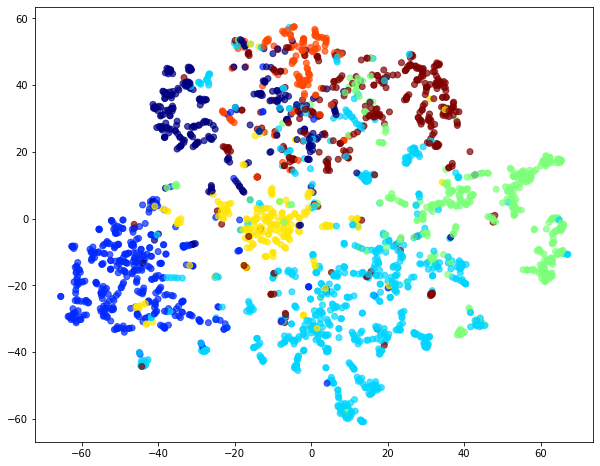

In [14]:
# draw the points
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(10, 8))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)

In [15]:
# X will hold the 128-dimensional input features
X = node_embeddings
# y holds the corresponding target values
y = np.array(node_targets)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, test_size=None)

In [17]:
print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (248, 128)
 y_train = (248,)
 X_test = (2237, 128)
 y_test = (2237,)


In [18]:
clf = LogisticRegressionCV(
    Cs=10, cv=10, scoring="accuracy", verbose=False, multi_class="ovr", max_iter=300
)
clf.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=300, multi_class='ovr', n_jobs=None, penalty='l2',
                     random_state=None, refit=True, scoring='accuracy',
                     solver='lbfgs', tol=0.0001, verbose=False)

In [19]:
y_pred = clf.predict(X_test)

In [20]:
accuracy_score(y_test, y_pred)

0.7805096110862763

In [ ]:
https://stellargraph.readthedocs.io/en/stable/demos/node-classification/node2vec-node-classification.html